In [1]:
import numpy as np
import copy
import MDAnalysis as mda
from MDAnalysis.analysis.base import AnalysisFromFunction
from MDAnalysis.coordinates.memory import MemoryReader # for faster processing
import MDAnalysis.transformations as trans
import nglview as nv
import matplotlib.pyplot as plt
import os
import time

/home/ac127777/anaconda3/envs/mdanalysis-dev/lib/python3.8/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
def getcoords(atomgroup):
    """
    Extracts the trajectory coords of an atom group as a numpy array
    
    Parameters
    ----------
    atomgroup : MDA AtomGroup object
        atomgroup = u.atoms or atomgroup = u.select_atoms(<selection>)
        
    Returns
    -------
    trajcoords : np.array
        trajectory coords as numpy array
    """
    trajcoords = AnalysisFromFunction(lambda cg: cg.positions.copy(), atomgroup.atoms).run().results['timeseries']
    return trajcoords

In [3]:
def getboxdimensions(atomgroup):
    """
    Computes the box dimensions for each frame of a trajectory of an atomgroup
    
    Parameters
    ----------
    atomgroup : MDA AtomGroup object
        atomgroup = u.atoms or atomgroup = u.select_atoms(<selection>)
    
    Returns
    -------
    edge_length : float
        average box edge length
    """
    xyz_coords = getcoords(atomgroup)

    for frame_nr, frame in enumerate(xyz_coords):

        n = 0
        while n < 3: # do for x,y,z
            if n == 0:

                xmax = np.max(frame[:,n])
                xmin = np.min(frame[:,n])

            elif n == 1:

                ymax = np.max(frame[:,n])
                ymin = np.min(frame[:,n])

            elif n == 2:

                zmax = np.max(frame[:,n])
                zmin = np.min(frame[:,n])    

            n = n + 1

        boxmax = np.stack((xmax,ymax,zmax)) # maximum dimensions of smaller box
        boxmin = np.stack((xmin,ymin,zmin)) # minimum dimensions of smaller box

        # combine frames into trajectory
        if frame_nr == 0:
            framemax = boxmax
            framemin = boxmin
        elif frame_nr == 1:
            framemax = np.stack((framemax,boxmax))
            framemin = np.stack((framemin,boxmin))
        else:
            framemax = np.append(framemax,np.atleast_2d(boxmax),axis=0)
            framemin = np.append(framemin,np.atleast_2d(boxmin),axis=0)

    edge_length = float(np.mean(np.array([np.mean(framemax[:,0]),np.mean(framemax[:,1]),np.mean(framemax[:,2])])) - np.abs(np.mean(np.array([np.mean(framemin[:,0]),np.mean(framemin[:,1]),np.mean(framemin[:,2])]))))
    
    # clean up RAM
    for data in [xyz_coords, boxmax, boxmin, framemax, framemin]:
        del data
    
    return edge_length

In [4]:
# read files
top = 'pdbtop.pdb'
traj = 'sampletraj.dcd'
u = mda.Universe(top,traj)

/home/ac127777/anaconda3/envs/mdanalysis-dev/lib/python3.8/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [5]:
edge_length = getboxdimensions(u.atoms)

In [6]:
edge_length

39.1132926940918

In [7]:
assert (edge_length != None) and (type(edge_length) is float), 'cell edge length not defined or wrong type'

... now generate a new psf file using charmm w/ genpsf.inp (change the names of the relevant input/output files in there)

In [8]:
os.system('charmm -i genpsf.inp -o genpsf.out')

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

0

rename the A column in the psf to MP1, WAT, SOD

### If necessary, cut traj into pieces to avoid RAM overflow

### center solute

load

In [8]:
top_psf = 'test.psf' # enter path to psf for big box generated with charmm -i genpsf.inp...

boxdimensions

In [9]:
boxcenter = np.array([edge_length/2, edge_length/2, edge_length/2])

In [10]:
def center_solute_ion(water_coords, solute_coords, ion_coords): 
    """
    centers the solute and the ion
    
    Parameters
    ----------
    water_coords : np.array
    solute_coords : np.array
    ion_coords : np.array
    
    Returns
    -------
    new_solute_coords : np.arary
        centered solute coords
    new_water_coords : np.array
        shifted water coords
    new_ion_coords : np.array
        centered ion coords
    
    """
    
    assert len(water_coords) != 0,'missing coordinates for water'
    assert len(solute_coords) != 0,'missing coordinates for solute' 
    assert len(ion_coords) != 0,'missing coordinates for ions' 

    new_solute_coords = np.full(solute_coords.shape,0,dtype=float)
    new_water_coords = np.full(water_coords.shape,0,dtype=float)
    new_ion_coords = np.full(ion_coords.shape,0,dtype=float)
    
    for frame_nr, frame in enumerate(solute_coords[:]): # calculate shift for each frame
        n = 0 # loop over xyz
        while n < 3:
            avg = (((np.sum(frame[:,n]))/(frame[:,n].size))+(ion_coords[frame_nr][:,n]))/2 # center btwn solute and ion
            shift_value = (edge_length/2) - avg
            if n==0:
                solute_x = np.full(solute_coords.shape[1], shift_value) # shift x dir to be applied to solute
                water_x = np.full(water_coords.shape[1], shift_value) # shift x dir to be applied to water
                ion_x = np.full(ion_coords.shape[1], shift_value) # shift x dir to be applied to ion
            elif n == 1:
                solute_y = np.full(solute_coords.shape[1], shift_value) # shift y dir
                water_y = np.full(water_coords.shape[1], shift_value)
                ion_y = np.full(ion_coords.shape[1], shift_value)
            elif n == 2:
                solute_z = np.full(solute_coords.shape[1], shift_value) # shift z dir
                water_z = np.full(water_coords.shape[1], shift_value)
                ion_z = np.full(ion_coords.shape[1], shift_value)
            n = n + 1

        stack1 = np.stack((solute_x, solute_y, solute_z),axis=1) # recombine x,y,z for 1 frame
        stack2 = np.stack((water_x,water_y,water_z),axis=1)   
        stack3 = np.stack((ion_x, ion_y, ion_z), axis=1)

        new_solute_coords[frame_nr] = np.add(frame, stack1)
        new_water_coords[frame_nr] = np.add(water_coords[frame_nr], stack2)
        new_ion_coords[frame_nr] = np.add(ion_coords[frame_nr], stack3)
        
    return new_solute_coords, new_water_coords, new_ion_coords

In [11]:
def center_solute(water_coords, solute_coords): 
    """
    centers the solute if there is no counterion
    
    Parameters
    ----------
    water_coords : np.array
    solute_coords : np.array
    
    Returns
    -------
    new_solute_coords : np.arary
        centered solute coords
    new_water_coords : np.array
        shifted water coords
    """
    assert len(water_coords)!=0,'missing coordinates for water'
    assert len(solute_coords)!=0,'missing coordinates for solute' 
    
    new_solute_coords = np.full(solute_coords.shape,0,dtype=float)
    new_water_coords = np.full(water_coords.shape,0,dtype=float)
    
    for frame_nr, frame in enumerate(solute_coords[:]): # calculate shift for each frame
        n = 0 # loop over xyz
        while n < 3:
            avg = (np.sum(frame[:,n]))/(frame[:,n].size) # center of geometry of solute
            shift_value = (edge_length/2) - avg
            if n==0:
                solute_x = np.full(solute_coords.shape[1], shift_value) # shift x dir to be applied to solute
                water_x = np.full(water_coords.shape[1], shift_value) # shift x dir to be applied to water
            elif n == 1:
                solute_y = np.full(solute_coords.shape[1], shift_value) # shift y dir
                water_y = np.full(water_coords.shape[1], shift_value)
            elif n == 2:
                solute_z = np.full(solute_coords.shape[1], shift_value) # shift z dir
                water_z = np.full(water_coords.shape[1], shift_value)
            n = n + 1

        stack1 = np.stack((solute_x, solute_y, solute_z),axis=1) # recombine x,y,z for 1 frame
        stack2 = np.stack((water_x,water_y,water_z),axis=1)   

        new_solute_coords[frame_nr] = np.add(frame, stack1)
        new_water_coords[frame_nr] = np.add(water_coords[frame_nr], stack2)
        
    return new_solute_coords, new_water_coords

In [12]:
def combine_groups(atomgroup_solute, atomgroup_water, solute_coords, water_coords):
    """
    merges atoms and coordinates of 2 groups
    
    Parameters
    ----------
    atomgroup_solute : mda.AtomGroup
        solute atomgroup
    atomgroup_water : mda.AtomGroup
        solvent atomgroup
    solute_coords : np.array
        solute coordinate array
    water_coords : np.array
        solvent coordinate array
        
    Returns
    -------
    combined_atomgroup : mda.AtomGroup
        all input atomgroups combined with coordinates
    """
    combined_atomgroup = mda.Merge(atomgroup_solute.atoms, atomgroup_water.atoms)# recombine atom info
    combined_coords = np.concatenate((solute_coords, water_coords), axis=1) # recombine coords
    combined_atomgroup.load_new(combined_coords, format=MemoryReader) # recombine atom info & coords
    
    return combined_atomgroup

In [13]:
def combine_moar_groups(atomgroup_solute, atomgroup_water, atomgroup_ion, solute_coords, water_coords, ion_coords):
    """
    merges atoms and coordinates of 3 groups
    
    Parameters
    ----------
    atomgroup_solute : mda.AtomGroup
        solute atomgroup
    atomgroup_water : mda.AtomGroup
        solvent atomgroup
    atomgroup_ion : mda.AtomGroup
        counterions atomgroup
    solute_coords : np.array
        solute coordinate array
    water_coords : np.array
        solvent coordinate array
    ion_coords : np.array
        counterions coordinate array
    
    Returns
    -------
    combined_atomgroup : mda.AtomGroup
        all input atomgroups combined with coordinates
    """
    combined_atomgroup = mda.Merge(atomgroup_solute.atoms, atomgroup_water.atoms, atomgroup_ion.atoms)# recombine atom info
    combined_coords = np.concatenate((solute_coords,water_coords,ion_coords), axis=1) # recombine coords
    combined_atomgroup.load_new(combined_coords, format=MemoryReader) # recombine atom info & coords
    
    return combined_atomgroup

In [14]:
def find_residue_names(universe):
    """
    Checks which solutes and which counterions are present and returns them as lists
    
    Parameters
    ----------
    universe : mda.Universe
    
    Returns
    -------
    solute_names : list
    ion_names : list
    """
    solutes = {'AP0':None,'AP1':None,'AP2':None,'EP0':None,'EP1':None,'EP2':None,'HP0':None,'HP1':None,'HP2':None,'LP0':None,'LP1':None,'LP2':None,'MP0':None,'MP_0':None,'MP_1':None,'MP1':None,'MP_2':None,'MP2':None,'MP_3':None,'PT0':None,'PT1':None,'PT2':None}
    # find matching solute name
    solute_names = []
    for name in list(solutes.keys()):
        solute_atomgroup = universe.select_atoms('resname ' + name)
        if len(solute_atomgroup) != 0:
            solute_names.append(name)
            solutes[name] = solute_atomgroup
            
    ions = {'SOD':None,'MAM':None,'MAMM':None,'MAM1':None,'MAM2':None,'NA':None,'Na':None,'GUA':None}
    # find matching ions name
    ion_names = []
    for name in list(ions.keys()):
        ions_atomgroup = universe.select_atoms('resname ' + name)
        if len(ions_atomgroup) != 0:
            ion_names.append(name)
            ions[name] = ions_atomgroup
            
    assert len(solute_names) <= 2, 'too many solutes, check input'
    assert len(ion_names) <= 4, 'too many ions, check input'
            
    return solute_names, ion_names

In [15]:
def center(edge_length, solvent_atomgroup, combined_atomgroup, centered_trajectory_name):
    """
    wraps solvent around centered solute and writes out trajectory
    
    Parameters
    ----------
    edge_length : float
        box edge length
    solvent_atomgroup : mda.AtomGroup
        solvent(incl. counterions)
    combined_atomgroup : mda.AtomGroup
        solute & solvent
    centered_trajectory_name : str
        e.g. 'centered_trajectory.dcd'
    
    Returns
    -------
    combined_atomgroup : mda.AtomGroup
        has atoms and coordinates with solute centered and solvent wrapped into box
    """
    dim = [edge_length, edge_length, edge_length, 90, 90, 90]
    transforms = [trans.boxdimensions.set_dimensions(dim),
                  trans.wrap(solvent_atomgroup,compound='residues')]

    combined_atomgroup.trajectory.add_transformations(*transforms)
    
    # write to file
    combined_atomgroup.atoms.write(str(centered_trajectory_name), frames = combined_atomgroup.trajectory)
    
    return combined_atomgroup

In [16]:
solute_names, ion_names = find_residue_names(u)

In [17]:
solute_names

['MP_1']

In [18]:
ion_names

['SOD']

In [19]:
u = mda.Universe(top_psf, 'sampletraj.dcd')

In [20]:
solvent_selection = 'resname TIP3 or resname SOD'

In [21]:
solute_selection = 'resname MP_1'

In [22]:
# select waters, sodiums, etc.
solvent_atomgroup = u.select_atoms(solvent_selection)
assert len(solvent_atomgroup) != 0, 'solvent atom group is empty, probably wrong residue names selected'
# get trajectory positions for atom groups
solvent_coords = getcoords(solvent_atomgroup)

In [23]:
solute_atomgroup = u.select_atoms(solute_selection)
assert len(solute_atomgroup) != 0, 'solute atom group is empty, probably wrong residue names selected'
solute_coords = getcoords(solute_atomgroup)

In [24]:
new_solute_coords, new_water_coords = center_solute(solvent_coords, solute_coords)
combined_atomgroup = combine_groups(solute_atomgroup, solvent_atomgroup, solute_coords, solvent_coords)

In [25]:
combined_atomgroup_centered = center(edge_length, solvent_atomgroup, combined_atomgroup, 'trajectory_centered.dcd')

### slice small boxes out of each frame

external read-in

In [26]:
top = 'pdbtop.pdb'
traj = 'trajectory_centered.dcd'
u = mda.Universe(top, traj)

In [27]:
# select waters, sodiums, etc.
solvent_atomgroup = u.select_atoms(solvent_selection)
assert len(solvent_atomgroup) != 0, 'solvent atom group is empty, probably wrong residue names selected'
# get trajectory positions for atom groups
solvent_coords = getcoords(solvent_atomgroup)

In [28]:
ion_atomgroup = u.select_atoms('resname SOD')
ion_coords = getcoords(ion_atomgroup) # coords of translated ion

In [29]:
water_atomgroup = u.select_atoms('resname TIP3')
water_coords = getcoords(water_atomgroup) # coords of translated water

In [30]:
edge_length

39.1132926940918

In [31]:
def get_smallbox_dimensions(smallbox_edge_length, **coord_arrays):
    """
    computes the possible dimensions of the small box for each frame and decides on its final values
    
    Parameters
    ----------
    smallbox_edge_length : float
        desired edge length of the small box
    **coord_arrays : 
        coordinate arrays of solute_coords = solute_coords_array (and optional ion_coords = ion_coords_array)
        
    Returns
    -------
    smallbox_max : float
        upper lim of small box
    smallbox_min : float
        lower lim of small box
    
    """
    assert len(list(coord_arrays.keys())) <= 2, 'a maximum of 2 coord arrays can be processed'
    
    framecenter = np.full((len(coord_arrays['solute_coords']), 3), 0, dtype=float)
    framemax = np.full((len(coord_arrays['solute_coords']), 3), 0, dtype=float)
    framemin = np.full((len(coord_arrays['solute_coords']), 3), 0, dtype=float)
    
    for frame_nr, frame in enumerate(coord_arrays['solute_coords']):
        
        n = 0
        while n < 3: # do for x,y,z
            if n == 0:
                
                # define dimensions of smaller box
                if len(list(coord_arrays.keys())) > 1:
                    xavg = ((np.mean(frame[:,n])) + np.mean(coord_arrays['ion_coords'][frame_nr][:,n]))/2
                    xmax = np.max(np.append(frame[:,n], coord_arrays['ion_coords'][frame_nr][:,n]))
                    xmin = np.min(np.append(frame[:,n], coord_arrays['ion_coords'][frame_nr][:,n]))
                else:
                    xavg = (np.mean(frame[:,n]))
                    xmax = np.max(frame[:,n])
                    xmin = np.min(frame[:,n])
                    
                xplus = float(xavg) + smallbox_edge_length/2
                xminus = float(xavg) - smallbox_edge_length/2
                # check if +/- 8 Angström is sufficient and increase if needed
                if xmax > xplus:
                    xplus = xmax
                if xmin < xminus:
                    xminus = xmin
                    
            elif n == 1:
                
                if len(list(coord_arrays.keys())) > 1:
                    yavg = ((np.mean(frame[:,n])) + np.mean(coord_arrays['ion_coords'][frame_nr][:,n]))/2
                    ymax = np.max(np.append(frame[:,n], coord_arrays['ion_coords'][frame_nr][:,n]))
                    ymin = np.min(np.append(frame[:,n], coord_arrays['ion_coords'][frame_nr][:,n]))
                else:
                    yavg = (np.mean(frame[:,n]))
                    ymax = np.max(frame[:,n])
                    ymin = np.min(frame[:,n])
                    
                yplus = float(yavg) + smallbox_edge_length/2
                yminus = float(yavg) - smallbox_edge_length/2
                # check if +/- 8 Angström is sufficient and increase if needed
                if ymax > yplus:
                    yplus = ymax
                if ymin < yminus:
                    yminus = ymin
                    
            elif n == 2:

                if len(list(coord_arrays.keys())) > 1:
                    zavg = ((np.mean(frame[:,n])) + np.mean(coord_arrays['ion_coords'][frame_nr][:,n]))/2
                    zmax = np.max(np.append(frame[:,n], coord_arrays['ion_coords'][frame_nr][:,n]))
                    zmin = np.min(np.append(frame[:,n], coord_arrays['ion_coords'][frame_nr][:,n]))
                else:
                    zavg = (np.mean(frame[:,n]))
                    zmax = np.max(frame[:,n])
                    zmin = np.min(frame[:,n])
                    
                zplus = float(zavg) + smallbox_edge_length/2
                zminus = float(zavg) - smallbox_edge_length/2
                # check if +/- 8 Angström is sufficient and increase if needed
                if zmax > zplus:
                    zplus = zmax
                if zmin < zminus:
                    zminus = zmin
                    
            n = n + 1
            
        center = np.stack((xavg, yavg, zavg), axis=0) # recombine x,y,z for 1 frame (geometric center of phos and ions)
        boxmax = np.stack((xplus, yplus, zplus), axis=0) # maximum dimensions of smaller box
        boxmin = np.stack((xminus, yminus, zminus), axis=0) # minimum dimensions of smaller box

        # fill empty traj
        framecenter[frame_nr] = center.T[0]
        framemax[frame_nr] = boxmax.T[0]
        framemin[frame_nr] = boxmin.T[0]
        
        
        
    # final small box dimensions
    smallbox_xmax = np.max(framemax[:,0])
    smallbox_ymax = np.max(framemax[:,1])
    smallbox_zmax = np.max(framemax[:,2])
    smallbox_max = np.stack((smallbox_xmax, smallbox_ymax, smallbox_zmax))

    smallbox_xmin = np.min(framemin[:,0])
    smallbox_ymin = np.min(framemin[:,1])
    smallbox_zmin = np.min(framemin[:,2])
    smallbox_min = np.stack((smallbox_xmin, smallbox_ymin, smallbox_zmin))
        
    return smallbox_max, smallbox_min

In [32]:
smallbox_edge_length = 16

In [33]:
smallbox_max, smallbox_min = get_smallbox_dimensions(smallbox_edge_length, solute_coords=new_solute_coords)

In [34]:
print(str(smallbox_max[0])+', '+str(smallbox_max[1])+', '+str(smallbox_max[2]))
print(str(smallbox_min[0])+', '+str(smallbox_min[1])+', '+str(smallbox_min[2]))

27.55664978027344, 27.55664978027344, 27.55664978027344
11.556642913818358, 11.556642913818358, 11.556642913818358


In [35]:
smallbox_max

array([27.55664978, 27.55664978, 27.55664978])

In [36]:
smallbox_min

array([11.55664291, 11.55664291, 11.55664291])

locate atoms outside small box

In [37]:
def find_molecules_outside_box(frame, smallbox_max, smallbox_min, solvent_atomgroup):
    """
    scans each frame for molecules outside the small box and returns their indices and residue numbers
    
    Parameters
    ----------
    frame : np.array
        trajectory coordinate frame
    smallbox_max : float
        upper lim of small box
    smallbox_min : float
        lower lim of small box
    solvent_atomgroup : mda.AtomGroup
        atomgroup that is to be scanned
        
    Returns
    -------
    atom_indices_outside_box : np.array
        indices of atoms located outside the defined box
    atom_resids_outside_box : np.array
        residue numbers of atoms located outside the defined box
    """
    # indices of atoms outside box (x,y,z)
    outside_box_x = []
    outside_box_y = []
    outside_box_z = []
    
    n = 0
    while n < 3: # x,y,z columns
        for index, positions in enumerate(frame[:,n]):
            
            # get indices of solvent atoms outside small box
            if (positions > smallbox_max[n] or positions < smallbox_min[n]) == True:
                if n == 0:
                    outside_box_x = np.append(outside_box_x, index)
                elif n == 1:
                    outside_box_y = np.append(outside_box_y, index)
                elif n == 2:
                    outside_box_z = np.append(outside_box_z, index)
        n = n + 1
    
    atom_indices_outside_box = np.unique(np.sort(np.concatenate((outside_box_x, outside_box_y, outside_box_z)))).astype('int') # combine all findings for 1 frame into 1 array, sort ascending, remove duplicates    
    
    
    # residue numbers of atoms outside box
    atom_resids_outside_box = []
    
    # collect residue numbers
    for index in atom_indices_outside_box:
        atom_resids_outside_box = np.append(atom_resids_outside_box, solvent_atomgroup[index].resid)
    
    atom_resids_outside_box = np.unique(atom_resids_outside_box).astype('int') # remove duplicates

    return atom_indices_outside_box, atom_resids_outside_box

get residue numbers of atoms outside box

Text(0, 0.5, 'number of residues outside box')

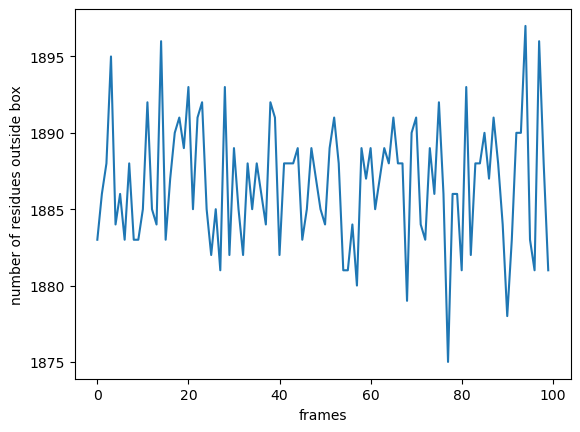

In [38]:
outbox_indices = [] # indices of water atoms outside of box for all frames
outbox_resids = [] # residue indices of water atoms outside of box for all frames
no_resnums = [] # number of residues for all frames

# loop over frames
for frame in water_coords:

    atom_indices_outside_box, atom_resids_outside_box = find_molecules_outside_box(frame, smallbox_max, smallbox_min, water_atomgroup)
    # combine frames into trajectory (nested list)
    outbox_indices.append(atom_indices_outside_box)
    outbox_resids.append(atom_resids_outside_box)
    no_resnums.append(len(atom_resids_outside_box))
        
plt.plot(np.linspace(0,len(no_resnums) - 1, len(no_resnums)), no_resnums) # shows volume/density fluctuations
plt.xlabel('frames')
plt.ylabel('number of residues outside box')

In [39]:
avg_resnums = int(np.around(np.mean(no_resnums)))

In [40]:
avg_resnums

1887

get ion residues outside box

Text(0, 0.5, 'number of residues outside box')

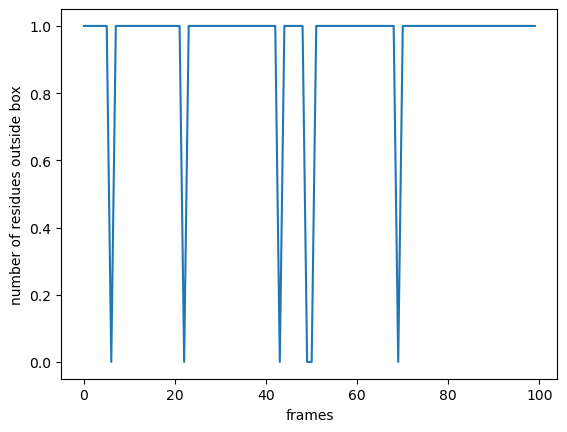

In [41]:
outbox_indices_ion = [] # indices of water atoms outside of box for all frames
outbox_resids_ion = [] # residue indices of water atoms outside of box for all frames
no_resnums_ion = [] # number of residues for all frames

# loop over frames
for frame in ion_coords:

    ion_atom_indices_outside_box, ion_atom_resids_outside_box = find_molecules_outside_box(frame, smallbox_max, smallbox_min, ion_atomgroup)
    # combine frames into trajectory (nested list)
    outbox_indices_ion.append(ion_atom_indices_outside_box)
    outbox_resids_ion.append(ion_atom_resids_outside_box)
    no_resnums_ion.append(len(ion_atom_resids_outside_box))
        
plt.plot(np.linspace(0,len(no_resnums_ion) - 1, len(no_resnums_ion)), no_resnums_ion) # shows volume/density fluctuations
plt.xlabel('frames')
plt.ylabel('number of residues outside box')

### equalize atom numbers & residue numbers

In [42]:
threshold = 0.005

In [43]:
class Equalizer:
    
    """
    Equalizes the number of residues outside the box by slightly adjusting the box volume
    
    Parameters
    ----------
    init_box_max : float
        maximum expansion of the box
    init_box_min : float
        minimum expansion of the box
    threshold : float
        defines the magnitude of the box size change
    no_resnums : list of int
        number of residues outside the box for each trajectory frame
    avg_resnums : int
        average number of residues outide the box over the trajectory
    coords : np.array
        atomic coordinate array
    atomgroup : mda.AtomGroup
        atom info
    
    Attributes
    ----------
    current_box_max : float
        maximum expansion of the box
    current_box_min : float
        minimum expansion of the box
    failures : int
        counter that is increased if shrinking/expanding does not yield a number of residues outside the box equal to avg_resnums
    fixfailures : int
        counter that is increased if the box_fix routine fails
    
    """
    
    def __init__(self, init_boxmax, init_boxmin, init_threshold, init_no_resnums, avg_resnums, coords, atomgroup):
        
        # initialize box dimensions
        self.init_box_max = init_boxmax
        self.init_box_min = init_boxmin       
        
        self.current_box_max = self.init_box_max
        self.current_box_min = self.init_box_min
        
        # initialize threshold
        self.init_threshold = init_threshold
        self.current_threshold = self.init_threshold
        
        # initialize resnums
        self.no_resnums = init_no_resnums
        self.avg_resnums = avg_resnums
        
        # initialize coords (1 frame) and atom info
        self.coords = coords
        self.atomgroup = atomgroup
        
        # fucked up geometry hotfix
        self.failures = 0
        self.fixfailures = 0
        
        
    def _adapt_threshold(self):
        """
        adapts the box shrinking/expansion threshold to smaller values the closer the number of residues outside the box 
        gets to avg_resnums
        
        Returns
        -------
        _adapted_theshold : float
            defines the magnitude of the box size change
        """
        
        if (np.abs(self.no_resnums - self.avg_resnums) == 3 and self.failures == 0) == True:
            
            _adapted_threshold = 0.0005
            
        elif (np.abs(self.no_resnums - self.avg_resnums) == 2 and self.failures == 0) == True:
            
            _adapted_threshold = 0.00025
        
        elif np.abs(self.no_resnums - self.avg_resnums) == 1 or self.failures > 0:
            
            _adapted_threshold = 0.000005
        
        else:
            
            _adapted_threshold = self.init_threshold
            
        return _adapted_threshold
    
    
    def shrink_box(self):
        """
        Shrinks the box gradually
        
        Returns
        -------
        atom_resids_outside_box :
            
        output : str
            info about the shrinking process
        _atom_resids_outside : np.array
            residue numbers of atoms located outside the defined box
            
        Attributes
        ----------
        no_resnums : int
            number of residues outside the box
        current_box_max : float
            maximum expansion of the box
        current_box_min : float
            minimum expansion of the box
        """
        
        output = 'too few waters: '+str(self.avg_resnums - self.no_resnums) + '\n' # refers to waters outside of box, hence 'too few'
        f = open('equalizer.out', 'a', encoding="utf-8")
        f.write('too few waters: '+str(self.avg_resnums - self.no_resnums) + '\n')
        f.close()
        
        if self.failures == 0:
            self.current_box_max = self.init_box_max
            self.current_box_min = self.init_box_min
        
        iterations = 0
        
        while self.no_resnums < self.avg_resnums:
            
            _threshold = self._adapt_threshold()
            self.current_threshold = _threshold
            
            if iterations > 300:
                _threshold = 0.0005
                self.current_threshold = _threshold

            # shrink box gradually
            self.current_box_max = self.current_box_max - _threshold
            self.current_box_min = self.current_box_min + _threshold  
            
            _atom_indices_outside, _atom_resids_outside = find_molecules_outside_box(self.coords, self.current_box_max, self.current_box_min, self.atomgroup)
            
            self.no_resnums = len(_atom_resids_outside)
            
            iterations += 1
            
            print('shrink iteration '+str(iterations)+' threshold '+str(_threshold)+' resids '+str(self.no_resnums)+' box '+str(self.current_box_max - self.current_box_min), end="\r") 
            time.sleep(0.03) 
            
        print('\n')    
        output = output + 'shrink box iterations: '+str(iterations) + '\n'
        f = open('equalizer.out', 'a', encoding="utf-8")
        f.write('shrink box iterations: '+str(iterations)+'\n')
        f.close() 
        
        # shrinking successful
        if self.no_resnums == self.avg_resnums:
            output = output + 'converged'
            f = open('equalizer.out', 'a', encoding="utf-8")
            f.write('converged\n')
            f.close()
            self.current_threshold = self.init_threshold
            self.failures = 0
            
        # shrinking failed    
        elif self.no_resnums != self.avg_resnums:
            output = output + 'resnum diff:  ' + str(self.avg_resnums - self.no_resnums) + '\n'
            f = open('equalizer.out', 'a', encoding="utf-8")
            f.write('resnum diff:  ' + str(self.avg_resnums - self.no_resnums) + '\n')
            f.close()
            self.failures += 1
            print('failures = '+str(self.failures))

        
        return _atom_resids_outside, output
    
    
    def expand_box(self):
        """
        expands the box gradually
        
        Returns
        -------
        atom_resids_outside_box :
            
        output : str
            info about the expansion process
        _atom_resids_outside : np.array
            residue numbers of atoms located outside the defined box
            
        Attributes
        ----------
        no_resnums : int
            number of residues outside the box
        current_box_max : float
            maximum expansion of the box
        current_box_min : float
            minimum expansion of the box
        """
        
        output = 'too many waters: '+str(self.no_resnums - self.avg_resnums) + '\n' # refers to waters outside of box, hence 'too many'
        f = open('equalizer.out', 'a', encoding="utf-8")
        f.write('too many waters: '+str(self.no_resnums - self.avg_resnums) + '\n')
        f.close()
        
        if self.failures == 0:
            self.current_box_max = self.init_box_max
            self.current_box_min = self.init_box_min
        
        iterations = 0
        
        while self.no_resnums > self.avg_resnums:

            _threshold = self._adapt_threshold()
            self.current_threshold = _threshold
            
            if iterations > 300:
                _threshold = 0.0005
                self.current_threshold = _threshold
            
            # expand box gradually
            self.current_box_max = self.current_box_max + _threshold
            self.current_box_min = self.current_box_min - _threshold  
            
            _atom_indices_outside, _atom_resids_outside = find_molecules_outside_box(self.coords, self.current_box_max, self.current_box_min, self.atomgroup)
            
            self.no_resnums = len(_atom_resids_outside)
            
            iterations += 1
            print('expand iteration '+str(iterations)+' threshold '+str(_threshold)+' resids '+str(self.no_resnums)+' box '+str(self.current_box_max - self.current_box_min), end="\r") 
            time.sleep(0.03) 
            
        print('\n')   
        output = output + 'expand box iterations: ' + str(iterations) + '\n'
        f = open('equalizer.out', 'a', encoding="utf-8")
        f.write('expand box iterations: ' + str(iterations) + '\n')
        f.close()
        
        #expansion successful
        if self.no_resnums == self.avg_resnums:

            output = output + 'converged'
            f=open('equalizer.out', 'a', encoding="utf-8")
            f.write('converged\n')
            f.close()
            self.current_threshold = self.init_threshold
            self.failures = 0
        
        #expansion failed
        elif self.no_resnums != self.avg_resnums:

            output = output +'resnum diff:  ' + str(self.no_resnums - self.avg_resnums) + '\n'
            f = open('equalizer.out', 'a', encoding="utf-8")
            f.write('resnum diff:  ' + str(self.no_resnums - self.avg_resnums) + '\n')
            f.close()
            self.failures += 1
            print('failures = '+str(self.failures))

        return _atom_resids_outside, output
    

    def shrink_box_fix(self):
        
        output = 'too few waters: '+str(self.avg_resnums - self.no_resnums)+'\n' # refers to waters outside of box, hence 'too few'
        f = open('equalizer.out', 'a', encoding="utf-8")
        f.write('too few waters: '+str(self.avg_resnums - self.no_resnums)+'\n')
        f.close()
        
        _threshold = self.current_threshold * 0.5 # set new threshold
        
        iterations = 0
        while self.no_resnums < self.avg_resnums:
            
            if iterations > 300:
                _threshold = _threshold * 0.5 # decrease further

            # shrink box gradually
            self.current_box_max = self.current_box_max - _threshold
            self.current_box_min = self.current_box_min + _threshold

            _atom_indices_outside, _atom_resids_outside = find_molecules_outside_box(self.coords, self.current_box_max, self.current_box_min, self.atomgroup)
            
            self.no_resnums = len(_atom_resids_outside)

            iterations =+ 1
            
            print('shrink_box_fix iteration '+str(iterations)+' threshold '+str(_threshold)+' resids '+str(self.no_resnums)+' box '+str(self.current_box_max - self.current_box_min), end="\r") 
            time.sleep(0.03) 
        
        output = output +'shrink box fix iterations: '+str(iterations)+'\n'
        f = open('equalizer.out', 'a', encoding="utf-8")
        f.write('shrink box fix iterations: '+str(iterations)+'\n')
        f.close()
        
        # shrinking successful
        if self.no_resnums == self.avg_resnums:
            output = output+'converged'
            f = open('equalizer.out', 'a', encoding="utf-8")
            f.write('converged\n')
            f.close()
            self.failures = 0
            self.fixfailures = 0
            self.current_threshold = self.init_threshold
            
        # shrinking failed
        elif self.no_resnums != self.avg_resnums:
            output = output +'resnum diff:  '+str(self.avg_resnums - self.no_resnums)+'\n'
            f = open('equalizer.out', 'a', encoding="utf-8")
            f.write('resnum diff:  '+str(self.avg_resnums - self.no_resnums)+'\n')
            f.close()
            self.current_threshold = _threshold
            self.fixfailures += 1
        
        return _atom_resids_outside, output

  
    def expand_box_fix(self):
        
        output = 'too many waters: '+str(self.no_resnums - self.avg_resnums)+'\n' # refers to waters outside of box, hence 'too many'
        f = open('equalizer.out', 'a', encoding="utf-8")
        f.write('too many waters: '+str(self.no_resnums - self.avg_resnums)+'\n')
        f.close()
        
        _threshold = self.current_threshold*0.5 # set new threshold
        
        iterations = 0
        while self.no_resnums > self.avg_resnums:
            
            if iterations > 300:
                _threshold = _threshold * 0.5 # decrease further

            # expand box gradually
            self.current_box_max = self.current_box_max + _threshold
            self.current_box_min = self.current_box_min - _threshold

            _atom_indices_outside, _atom_resids_outside = find_molecules_outside_box(self.coords, self.current_box_max, self.current_box_min, self.atomgroup)

            self.no_resnums = len(_atom_resids_outside)

            iterations += 1
                        
            print('expand_box_fix iteration '+str(iterations)+' threshold '+str(_threshold)+' resids '+str(self.no_resnums)+' box '+str(self.current_box_max - self.current_box_min), end="\r") 
            time.sleep(0.03) 
           
        output = output +'expand box fix iterations: '+str(iterations)+'\n'
        f = open('equalizer.out', 'a', encoding="utf-8")
        f.write('expand box fix iterations: '+str(iterations)+'\n')
        f.close()
        
        # expnasion successful
        if self.no_resnums == self.avg_resnums:

            output = output +'converged'
            f = open('equalizer.out', 'a', encoding="utf-8")
            f.write('converged\n')
            f.close()
            self.failures = 0
            self.fixfailures = 0    
            self.current_threshold = self.init_threshold
            
        # expansion failed
        elif self.no_resnums != self.avg_resnums:

            output = output +'resnum diff:  '+str(self.no_resnums - self.avg_resnums)+'\n'
            f = open('equalizer.out', 'a', encoding="utf-8")
            f.write('resnum diff:  '+str(self.no_resnums - self.avg_resnums)+'\n')
            f.close()
            self.current_threshold = _threshold
            self.fixfailures += 1

        return _atom_resids_outside, output
    

    def choose_modification(self): 
        """
        checks if the number of residues outside the box is lower or higher than avg_resnums and inits either shrinking 
        or expansion 
        
        Returns
        -------
        atom_residues_outside : np.array
            residue numbers of atoms located outside the defined box
        no_resnums : int
            number of residues outside the box
        printout : str
            info/status of Equalizer
        
        Attributes
        ----------
        atom_residues_outside : np.array
            residue numbers of atoms located outside the defined box
        """
        
        if (self.no_resnums < self.avg_resnums and self.failures < 2) == True:
            
            self.atom_residues_outside, output = self.shrink_box()
            printout = output
            #print('\n hullo '+str(self.no_resnums), end='\r')
            time.sleep(1)
            
        elif (self.no_resnums > self.avg_resnums and self.failures < 2) == True:
            
            self.atom_residues_outside, output = self.expand_box()
            printout = output
            #print('\n hi '+str(self.no_resnums), end='\r')
            time.sleep(1)
            
        elif (self.no_resnums < self.avg_resnums and self.failures >= 2 and self.fixfailures <= 10) == True:
            
            self.atom_residues_outside, output  = self.shrink_box_fix()
            printout = output
        
        elif (self.no_resnums > self.avg_resnums and self.failures >= 2 and self.fixfailures <= 10) == True:
            
            self.atom_residues_outside, output  = self.expand_box_fix()
            printout = output
            
        elif (self.no_resnums != self.avg_resnums and self.failures >= 2 and self.fixfailures > 10) == True:
            
            f = open('equalizer.out', 'a', encoding="utf-8")
            f.write('skipping frame nr '+str(frame_nr)+'\n')
            f.close()
            
            self.atom_residues_outside = np.array([0])
            printout = 'skipping frame nr '+str(frame_nr)+'\n'
            
        elif self.no_resnums == self.avg_resnums:
            
            printout = ''
            
        return self.atom_residues_outside, self.no_resnums, printout

frame nr 0
shrink iteration 347 threshold 0.0005 resids 1887 box [15.90572687 15.90572687 15.90572687]

too few waters: 4
shrink box iterations: 347
converged
frame nr 1
shrink iteration 334 threshold 0.0005 resids 1887 box [15.96399687 15.96399687 15.96399687]

too few waters: 1
shrink box iterations: 334
converged
frame nr 2
expand iteration 316 threshold 0.0005 resids 1887 box [16.01801687 16.01801687 16.01801687]

too many waters: 1
expand box iterations: 316
converged
frame nr 3
expand iteration 336 threshold 0.0005 resids 1887 box [16.22224687 16.22224687 16.22224687]

too many waters: 8
expand box iterations: 336
converged
frame nr 4
shrink iteration 404 threshold 0.0005 resids 1887 box [15.73650687 15.73650687 15.73650687]]

too few waters: 3
shrink box iterations: 404
converged
frame nr 5
shrink iteration 347 threshold 0.0005 resids 1887 box [15.95099687 15.95099687 15.95099687]

too few waters: 1
shrink box iterations: 347
converged
frame nr 6
shrink iteration 329 threshold 0

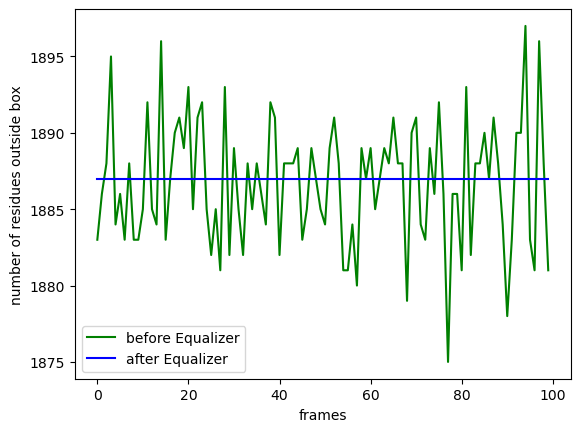

In [46]:
LINE_CLEAR = '\x1b[2K' # <-- ANSI sequence

os.system('rm equalizer.out')
f = open('equalizer.out', 'w', encoding="utf-8")

outbox_resids_copy = copy.deepcopy(outbox_resids) # residue indices of water atoms outside of box for all frames
no_resnums_copy = copy.deepcopy(no_resnums) # number of residues for all frames

for frame_nr, outbox_resids_frame in enumerate(outbox_resids_copy[:]): # loop over trajectory
    
    f = open('equalizer.out', 'a', encoding = "utf-8")
    f.write('frame nr '+str(frame_nr)+'\n')
    f.close()
    
    printout = 'frame nr '+str(frame_nr)
    print(printout)

    # equalize number of atoms & residues
    if no_resnums_copy[frame_nr] != avg_resnums: 

        no_resnums_frame = no_resnums_copy[frame_nr]

        box_modified = Equalizer(smallbox_max, smallbox_min, threshold, no_resnums_frame, avg_resnums, water_coords[frame_nr], water_atomgroup)

        printout = ''

        while no_resnums_frame != avg_resnums:

            frame_resids, no_resnums_frame, output = box_modified.choose_modification()
            #print('\n miep '+str(no_resnums_frame))
            print(output)
            printout += output          

        if box_modified.fixfailures > 10: # indicator to skip frame later on

            no_resnums_copy[frame_nr] = 0

        else:

            no_resnums_copy[frame_nr] = no_resnums_frame

        outbox_resids_copy[frame_nr] = frame_resids.astype('int')

        print(end = LINE_CLEAR)


plt.plot(np.linspace(0, len(no_resnums) - 1, len(no_resnums)), no_resnums, color='green', label='before Equalizer') 
plt.plot(np.linspace(0, len(no_resnums_copy) - 1, len(no_resnums_copy)), no_resnums_copy, color='blue', label='after Equalizer') # finally homogeneous
plt.xlabel('frames')
plt.ylabel('number of residues outside box')
plt.legend(loc=0)

In [47]:
# collect residues outside box as atom groups        
waters2delete = [] # atom groups of waters outside box go in here for each frame

for frame_nr, frame in enumerate(outbox_resids_copy):
    
    if no_resnums_copy[frame_nr] != 0:
        
        for res_nr, residue in enumerate(frame): # residuewise for each frame
            
            if res_nr == 0: # initialize atom group
                
                waters_outside = water_atomgroup.select_atoms('resid '+str(residue))
                
            else:
                waters_outside = waters_outside.concatenate(water_atomgroup.select_atoms('resid '+str(residue))) # append next water molecule to atom group
        
        waters2delete.append(waters_outside) # append atom group for frame
        
    else: 
        waters2delete.append(water_atomgroup.select_atoms('resname NOPE'))

In [48]:
# collect residues inside box as atom groups
waters_in_box = [] # atom groups of water in box go in here

for frame in waters2delete:
    
    if len(frame) != 0:
        
        water_in_box = water_atomgroup.subtract(frame)
        waters_in_box.append(water_in_box)
        
    else:
        waters_in_box.append(frame)

In [49]:
# slice and collect relevant coordinates of waters inside box
for frame_nr, frame in enumerate(waters_in_box):
    
    if len(frame) != 0: # skip frames w/ fucked geometry
        
        water_in_box_coords_frame = getcoords(frame)[frame_nr]
        # combine into traj
        if frame_nr == 0: # initialize trajectory (as numpy array)
            
            water_in_box_coords = water_in_box_coords_frame
            print(water_in_box_coords.shape)
            
        elif frame_nr == 1:
            
            water_in_box_coords = np.stack((water_in_box_coords, water_in_box_coords_frame))
            print(water_in_box_coords.shape)
            
        else:
            water_in_box_coords = np.append(water_in_box_coords, np.atleast_3d(water_in_box_coords_frame.T).T, axis=0) # correct stacking w/ correct dimensions

(348, 3)
(2, 348, 3)


In [52]:
water_in_box_coords.shape

(100, 348, 3)

In [50]:
# skip frames w/ fucked geometry
frames2delete = np.argwhere(np.array(no_resnums_copy)==0)
solute_coords_edit = np.delete(solute_coords,frames2delete, axis=0)
ion_coords_edit = np.delete(ion_coords,frames2delete, axis=0)

# merge        
smallbox_crude = combine_moar_groups(solute_atomgroup, ion_atomgroup, water_atomgroup[:len(waters_in_box[0])], solute_coords_edit, ion_coords_edit, water_in_box_coords)

In [73]:
# align box with origin
edgelengths = smallbox_max - smallbox_min

if water_atomgroup.atoms[0].resid == water_atomgroup.atoms[0].resnum == 1: # fix residue numbers
    
    smallbox = combine_moar_groups(solute_atomgroup, ion_atomgroup, water_atomgroup[3*(len(solute_names)+len(ion_names)):len(waters_in_box[0])+3*(len(solute_names)+len(ion_names))], solute_coords_edit, ion_coords_edit, water_in_box_coords) #deepcopy not applicable -.-

elif water_atomgroup.atoms[0].resid == water_atomgroup.atoms[0].resnum == (len(solute_names)+len(ion_names)+2):
    
    smallbox = combine_moar_groups(solute_atomgroup, ion_atomgroup, water_atomgroup[:len(waters_in_box[0])], solute_coords_edit, ion_coords_edit, water_in_box_coords)
    
elif water_atomgroup.atoms[0].resid == water_atomgroup.atoms[0].resnum == (len(solute_names)+len(ion_names)+1):
    
    smallbox = smallbox_crude

else:
    raise ValueError('Something wrong with the water residue numbers here')

In [74]:
smallbox_dim = [edgelengths[0], edgelengths[1], edgelengths[2], 90, 90, 90]
transforms = [trans.boxdimensions.set_dimensions(smallbox_dim),
              trans.center_in_box(solute_atomgroup, center='geometry'),
              trans.wrap(water_atomgroup[:len(waters_in_box[0])].atoms, compound='residues')]

In [75]:
smallbox.trajectory.add_transformations(*transforms)

# file output
smallbox.atoms.write('smallbox.dcd', frames = smallbox.trajectory)


oneframe = smallbox.atoms
oneframe.write('smallbox_1f.pdb', frames = smallbox.trajectory[0:1])

/home/ac127777/anaconda3/envs/mdanalysis-dev/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/ac127777/anaconda3/envs/mdanalysis-dev/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/ac127777/anaconda3/envs/mdanalysis-dev/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/home/ac127777/anaconda3/envs/mdanalysis-dev/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/ac127777/anac

edit the segid column in your smallbox_1f.pdb and remove 'SYST' (cp2k won't be able to read it properly)

have your charmm param files ready....

use genpsf.inp in charmm to generate the psf topology file for the small box

In [76]:
os.system('charmm -i genpsf_smallbox.inp -o genpsf_smallbox.out')

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

0

rename the 'A' column in the psf to WAT, SOD, MP0....